# Lego Classification System

## Overview

**Goal:** Find the most optimal classification model to predict images of Lego Minifigures accurately.

NOTE: Because this is a dataset of images, we may not be able to perform a full EDA on it.

### Load our data

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow
from tensorflow.io import read_file
from tensorflow import image
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPool2D, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [24]:
training_data_df = pd.read_csv("../data/index.csv")
training_data_df.head()

,path,class_id
0,marvel/0001/001.jpg,1
1,marvel/0001/002.jpg,1
2,marvel/0001/003.jpg,1
3,marvel/0001/004.jpg,1
4,marvel/0001/005.jpg,1


In [25]:
meta_data_df = pd.read_csv("../data/metadata.csv", encoding="cp1252")
meta_data_df.head()

,class_id,lego_ids,lego_names,minifigure_name
0,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
1,2,[76115],['Spider Mech vs. Venom'],VENOM
2,3,[76115],['Spider Mech vs. Venom'],AUNT MAY
3,4,[76115],['Spider Mech vs. Venom'],GHOST SPIDER
4,5,[75208],"[""Yoda's Hut""]",YODA


In [26]:
test_data_df = pd.read_csv("../data/test.csv")
test_data_df.head()

,path,class_id
0,test/001.jpg,32
1,test/002.jpg,32
2,test/003.jpg,32
3,test/004.jpg,32
4,test/005.jpg,1


We have to merge `meta_data_df` with the train and test data from the `class_id` field, since the metadata has all the information about which Minifigure we're looking at.

In [27]:
training_data_df = training_data_df.merge(meta_data_df, on="class_id")
training_data_df.head()

,path,class_id,lego_ids,lego_names,minifigure_name
0,marvel/0001/001.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
1,marvel/0001/002.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
2,marvel/0001/003.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
3,marvel/0001/004.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
4,marvel/0001/005.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN


In [28]:
test_data_df = test_data_df.merge(meta_data_df, on="class_id")
test_data_df.head()

,path,class_id,lego_ids,lego_names,minifigure_name
0,test/001.jpg,32,[75273],"[""Poe Dameron's X-wing Fighter""]",JANNAH
1,test/002.jpg,32,[75273],"[""Poe Dameron's X-wing Fighter""]",JANNAH
2,test/003.jpg,32,[75273],"[""Poe Dameron's X-wing Fighter""]",JANNAH
3,test/004.jpg,32,[75273],"[""Poe Dameron's X-wing Fighter""]",JANNAH
4,test/005.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN


### Visualize the images

In [29]:
# Get random image
rand_img = training_data_df.sample(1)
rand_img

,path,class_id,lego_ids,lego_names,minifigure_name
191,marvel/0008/011.jpg,20,[76162],"[""Black Widow's Helicopter Chase""]",BLACK WIDOW


In [30]:
# Get random image path
img_path = "../images/" + rand_img["path"].to_string(index=False)

# Read in the image
img = read_file(img_path)

# Decode the read file into a tensor
img = image.decode_image(img)

# Resize the image
img = image.resize(img, size = [240,240])
img

<tf.Tensor: shape=(240, 240, 3), dtype=float32, numpy=
array([[[158.62445 ,  67.19111 ,  82.19111 ],
        [159.93001 ,  66.96    ,  80.87    ],
        [185.61667 ,  71.844444,  88.05556 ],
        ...,
        [211.86667 , 215.86667 , 216.86667 ],
        [211.43333 , 215.43333 , 216.43333 ],
        [211.43333 , 215.43333 , 216.43333 ]],

       [[167.90334 ,  67.60333 ,  85.70333 ],
        [169.11    ,  69.369995,  85.58    ],
        [174.6     ,  66.2     ,  84.316666],
        ...,
        [208.3     , 212.3     , 213.3     ],
        [208.3     , 212.3     , 213.3     ],
        [208.3     , 212.3     , 213.3     ]],

       [[178.8389  ,  55.33889 ,  73.505554],
        [177.1     ,  56.416668,  75.86667 ],
        [161.99998 ,  47.027775,  66.02777 ],
        ...,
        [203.33333 , 209.33333 , 209.33333 ],
        [203.33333 , 209.33333 , 209.33333 ],
        [203.33333 , 209.33333 , 209.33333 ]],

       ...,

       [[255.      , 255.      , 255.      ],
        [255.

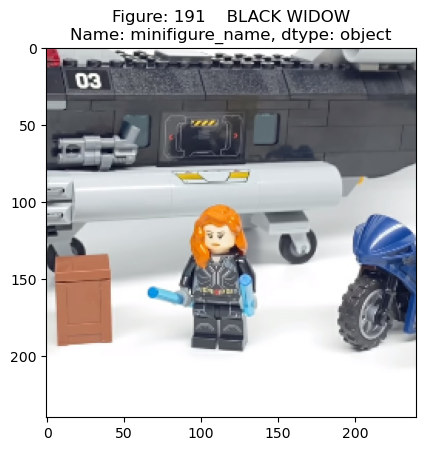

In [31]:
plt.imshow(img/255.)
plt.title(f'Figure: {rand_img["minifigure_name"]}')
plt.show()

Yay! We know what the images look like now. This concludes our EDA, as there aren't a lot of inferential questions we can ask with an image dataset. Let's move on to modeling.

## Modeling
### Prep the Image Data

In [32]:
IMG_SIZE = 240
PATH = "../images/"

# This function is taken from: https://www.kaggle.com/code/danielbeltran/learning-deep-learning-tensorflow-with-lego#First-model:-Multilayer-Perceptron-(MLP)
def load_data_in_tf(dataframe, batch_size = 32, img_size = IMG_SIZE, directory_path = PATH, rescale = True):
    '''
    Generates the TensorFlow Dataset and preprocess all the images in it
    
    Parameters
    ----------
    dataframe: pd.DataFrame
        Dataframe that contains the paths to each images and the target name.
        
    batch_size: int
        Size of batches.
        
    img_size: int
        Size of the resizing for the images.
        
    directory_path: str
        Main path that will be added to the dataframe path information.
    
    '''

    # Data augmentation pipeline
    if rescale:
        datagen = ImageDataGenerator(rescale=1./255)
    else:
        datagen = ImageDataGenerator()

    # Reading files from path in data frame
    tf_dataset = datagen.flow_from_dataframe(dataframe,
                                            directory = directory_path,
                                            x_col = "path",
                                            y_col = "minifigure_name",
                                            target_size = (img_size, img_size),
                                            batch_size = batch_size,)
    return tf_dataset



train_ds = load_data_in_tf(training_data_df)
test_ds = load_data_in_tf(test_data_df)

Found 371 validated image filenames belonging to 37 classes.
Found 79 validated image filenames belonging to 37 classes.


### Multilayer Perceptron (MLP)

In [33]:
# Create Model
mlp_model = Sequential([
        Input(shape = (train_ds.image_shape), name = 'input'),
        Flatten(name= 'flatten'),
        Dense(100, activation='relu', name= 'first_hidd_layer'),
        Dense(64, activation='relu', name= 'second_hidd_layer'),
        Dense(37, activation='softmax', name='output_layer')
], name = 'MLP')

# Compile the model
mlp_model.compile(loss = "categorical_crossentropy",
            optimizer = Adam(learning_rate = 0.001),
             metrics = ['accuracy'])

mlp_model.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 172800)            0         
_________________________________________________________________
first_hidd_layer (Dense)     (None, 100)               17280100  
_________________________________________________________________
second_hidd_layer (Dense)    (None, 64)                6464      
_________________________________________________________________
output_layer (Dense)         (None, 37)                2405      
Total params: 17,288,969
Trainable params: 17,288,969
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = mlp_model.fit(train_ds,
                        validation_data= test_ds,
                        epochs=50,
                        batch_size=32,
                        steps_per_epoch= len(train_ds),
                        validation_steps=len(test_ds),
                        callbacks=[early_stopping])

Epoch 1/50
12/12 [==============================] - 6s 357ms/step - loss: 77.1774 - accuracy: 0.0333 - val_loss: 76.2752 - val_accuracy: 0.0253
Epoch 2/50
12/12 [==============================] - 5s 398ms/step - loss: 53.8284 - accuracy: 0.0368 - val_loss: 25.4742 - val_accuracy: 0.0253
Epoch 3/50
12/12 [==============================] - 4s 326ms/step - loss: 15.0621 - accuracy: 0.0439 - val_loss: 6.4865 - val_accuracy: 0.0380
Epoch 4/50
12/12 [==============================] - 3s 255ms/step - loss: 4.5304 - accuracy: 0.0484 - val_loss: 3.6121 - val_accuracy: 0.0253
Epoch 5/50
12/12 [==============================] - 3s 286ms/step - loss: 3.6088 - accuracy: 0.0340 - val_loss: 3.6156 - val_accuracy: 0.0506
Epoch 6/50
12/12 [==============================] - 3s 282ms/step - loss: 3.5875 - accuracy: 0.0633 - val_loss: 3.6117 - val_accuracy: 0.0380
Epoch 7/50
12/12 [==============================] - 3s 236ms/step - loss: 3.6104 - accuracy: 0.0526 - val_loss: 3.6115 - val_accuracy: 0.0380
E

Test Accuracy: 0.04


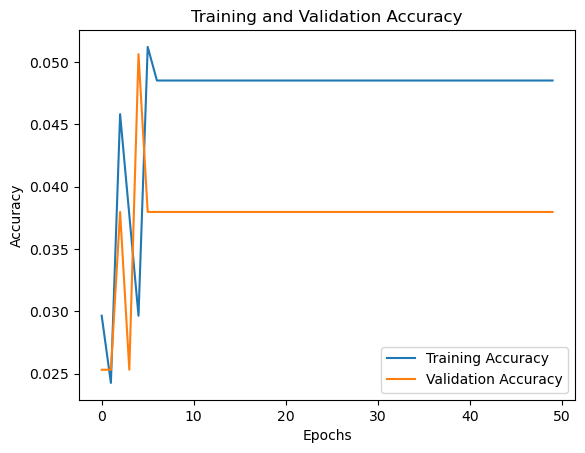

In [35]:
# Evaluate on the test set
test_loss, test_accuracy = mlp_model.evaluate(test_ds, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Convolutional Neural Network (CNN)

In [41]:
# Input layer
input_layer = Input(shape = (train_ds.image_shape),
                    name = "input")

# Two convolutional layer steps to create feature mapping
convolutional_layer_1 =   Conv2D(filters=10,
                                 kernel_size=3,
                                 padding="Same",
                                 activation="relu")
convolutional_layer_2 =   Conv2D(filters=10,
                                 kernel_size=3,
                                 padding="Same",
                                 activation="relu")

# Two corresponding pooling layers to reduce convolved dimensionality
pooling_layer_1 =         MaxPool2D(pool_size=2,
                                    padding="valid")
pooling_layer_2 =         MaxPool2D(pool_size=2,
                                    padding="valid")

# Three dropout layers: two for the convolutions and one for the ANN
dropout_layer_1 =         Dropout(0.25)
dropout_layer_2 =         Dropout(0.25)
dropout_layer_3 =         Dropout(0.5)

# A flattening layer for ingestion into the ANN
flattening_layer_1 =      Flatten()

# Two dense layers to make up the significant ANN architecture
connective_layer_1 =      Dense(256,
                                activation="relu")
output_layer =            Dense(37,
                                activation="softmax")

In [42]:
# Initialize sequential model schema
cnn_model = Sequential()

# Add Input layer
cnn_model.add(input_layer)

# Add first convolutional feature mapping process layers
cnn_model.add(convolutional_layer_1)
cnn_model.add(pooling_layer_1)
cnn_model.add(dropout_layer_1)

# Add second convolutional feature mapping process layers
cnn_model.add(convolutional_layer_2)
cnn_model.add(pooling_layer_2)
cnn_model.add(dropout_layer_2)

# Add image vectorization process layer
cnn_model.add(flattening_layer_1)

# Add connective ANN process layers
cnn_model.add(connective_layer_1)
cnn_model.add(dropout_layer_3)
cnn_model.add(output_layer)

# Summarize model layering setup
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 240, 240, 10)      280       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 120, 120, 10)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 120, 120, 10)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 120, 120, 10)      910       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 60, 60, 10)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 60, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 36000)            

In [43]:
# Define Adam optimization
optimizer = Adam(learning_rate=0.001)

# Set compilation properties
cnn_model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Set epochs and batch size
epochs, batch_size = 10, 500

In [44]:
"""# Create image augmentation engine as generator-like object
generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
)

# Fit training data to augmentation generator
generator.fit(train_ds)"""

'# Create image augmentation engine as generator-like object\ngenerator = ImageDataGenerator(\n    featurewise_center=False,\n    samplewise_center=False,\n    featurewise_std_normalization=False,\n    samplewise_std_normalization=False,\n    zca_whitening=False,\n    rotation_range=5,\n    zoom_range=0.1,\n    width_shift_range=0.1,\n    height_shift_range=0.1,\n    horizontal_flip=False,\n    vertical_flip=False,\n)\n\n# Fit training data to augmentation generator\ngenerator.fit(train_ds)'

In [45]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = cnn_model.fit(train_ds,
                        validation_data= test_ds,
                        epochs=epochs,
                        batch_size=batch_size,
                        steps_per_epoch= len(train_ds),
                        validation_steps=len(test_ds),
                        callbacks=[early_stopping])

Epoch 1/10
12/12 [==============================] - 8s 606ms/step - loss: 10.9314 - accuracy: 0.0265 - val_loss: 3.6168 - val_accuracy: 0.0253
Epoch 2/10
12/12 [==============================] - 7s 535ms/step - loss: 3.6341 - accuracy: 0.0140 - val_loss: 3.6107 - val_accuracy: 0.0253
Epoch 3/10
12/12 [==============================] - 7s 530ms/step - loss: 3.6104 - accuracy: 0.0305 - val_loss: 3.6105 - val_accuracy: 0.0380
Epoch 4/10
12/12 [==============================] - 6s 521ms/step - loss: 3.6105 - accuracy: 0.0370 - val_loss: 3.6103 - val_accuracy: 0.0380
Epoch 5/10
12/12 [==============================] - 6s 510ms/step - loss: 3.6104 - accuracy: 0.0386 - val_loss: 3.6101 - val_accuracy: 0.0380
Epoch 6/10
12/12 [==============================] - 6s 503ms/step - loss: 3.6094 - accuracy: 0.0598 - val_loss: 3.6098 - val_accuracy: 0.0380
Epoch 7/10
12/12 [==============================] - 7s 625ms/step - loss: 3.6090 - accuracy: 0.0441 - val_loss: 3.6096 - val_accuracy: 0.0380
Epoch

Test Accuracy: 0.04


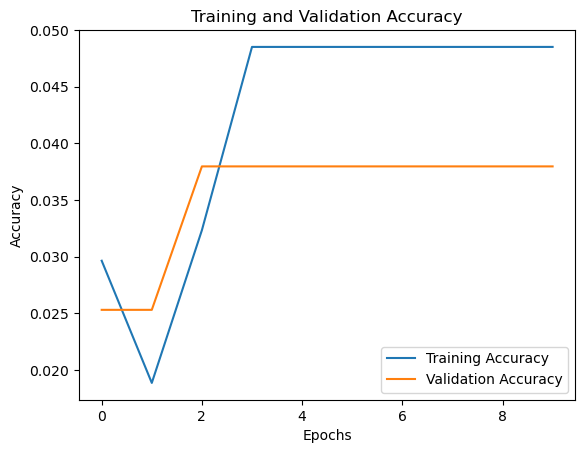

In [46]:
# Evaluate on the test set
test_loss, test_accuracy = mlp_model.evaluate(test_ds, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### CNN Pt. 2

In [50]:
# Create a model use Functional API
inputs = Input(shape = (train_ds.image_shape), name = 'input')
x = Conv2D(filters = 10, activation = 'relu', kernel_size = 3, name = 'conv_1_1')(inputs)
x = Conv2D(filters = 10, activation = 'relu', kernel_size = 3, name = 'conv_1_2')(x)
x = MaxPool2D(pool_size = 2, padding = 'valid', name = 'max_pool_1')(x)
x = Conv2D(filters = 10, activation = 'relu', kernel_size = 3, name = 'conv_2_1')(x)
x = Conv2D(filters = 10, activation = 'relu', kernel_size = 3, name = 'conv_2_2')(x)
x = MaxPool2D(pool_size = 2, padding = 'valid', name = 'max_pool_2')(x)
x = Flatten(name='flatten_layer')(x)
outputs = Dense(37, activation='softmax', name='output_layer')(x)

model_tiny_vgg = Model(inputs, outputs)

# Compile the model
model_tiny_vgg.compile(loss = "categorical_crossentropy",
                        optimizer = Adam(learning_rate = 0.001),
                         metrics = ['accuracy'])

model_tiny_vgg.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 240, 240, 3)]     0         
_________________________________________________________________
conv_1_1 (Conv2D)            (None, 238, 238, 10)      280       
_________________________________________________________________
conv_1_2 (Conv2D)            (None, 236, 236, 10)      910       
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 118, 118, 10)      0         
_________________________________________________________________
conv_2_1 (Conv2D)            (None, 116, 116, 10)      910       
_________________________________________________________________
conv_2_2 (Conv2D)            (None, 114, 114, 10)      910       
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 57, 57, 10)        0   

In [ ]:
# Training
# Train the model
history = cnn_model.fit(train_ds,
                        validation_data= test_ds,
                        epochs=epochs,
                        batch_size=batch_size,
                        steps_per_epoch= len(train_ds),
                        validation_steps=len(test_ds),
                        callbacks=[early_stopping])
history  = model_tiny_vgg.fit(train_ds,
                              epochs = epochs,
                              steps_per_epoch=len(train_ds),
                              validation_data = test_ds,
                              validation_steps = len(test_ds),
                              callbacks=[early_stopping])

Present on both capstone projects
- major capstone presentation, focus either on the business (updates and improvements of the intended goals and next steps moving forward) or the users (the implementation and how to use it like a tutorial)
- show and tell of the other capstone project (no slides)